# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [13]:
%pip install gymnasium


Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd
from pathlib import Path
import gymnasium as gym


data_path = Path("data") / "train.xlsx"

price_list = pd.read_excel(
    data_path,
    header=0,
    parse_dates=[0],
)

# Set the first column (date) as index
price_list = (
    price_list
    .set_index(price_list.columns[0])
    .rename_axis("date")
)

# Standardize column names to HH:00 format
price_list.columns = [f"{hour:02d}:00" for hour in range(1, len(price_list.columns) + 1)]

# Create the flat array for the environment
training_prices = price_list.to_numpy().ravel()

price_list.head()

,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,10:00,...,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00,24:00
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,24.31,24.31,21.71,8.42,0.01,0.01,0.02,0.01,0.01,6.31,...,15.00,10.00,8.17,27.77,37.99,33.11,37.99,33.00,36.48,30.65
2007-01-02,16.01,11.00,9.01,7.50,9.00,7.45,16.50,28.01,29.96,39.60,...,37.57,36.45,37.99,53.00,59.69,50.09,50.00,36.22,31.09,29.84
2007-01-03,28.00,24.50,24.15,18.99,15.50,23.11,29.01,39.73,43.81,49.09,...,43.21,43.99,48.00,57.00,60.99,55.51,51.77,34.51,39.31,38.05
2007-01-04,31.01,28.69,27.00,24.20,12.02,27.00,28.00,34.85,41.31,42.03,...,40.01,38.00,42.66,53.00,58.99,53.50,44.01,35.00,34.46,31.57
2007-01-05,22.00,19.50,17.55,15.91,11.40,22.65,27.30,34.00,40.01,45.00,...,40.06,38.00,38.61,49.84,53.00,45.91,36.74,29.61,30.61,27.51


In [15]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from dataclasses import dataclass
from typing import Optional, Dict, Any

@dataclass
class DamConfig:
    prices: np.ndarray
    Wmax: float = 100_000.0
    Vmax: float = 18_000.0
    W_init: float = 50_000.0
    g: float = 9.81
    rho: float = 1000.0
    h: float = 30.0
    eta_turbine: float = 0.9
    eta_pump: float = 0.8


class DamEnvGym(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, config: DamConfig):
        super().__init__()
        self.cfg = config

        # --- action & observation spaces ---
        self.action_space = spaces.Discrete(3)  # idle, sell, buy
        self.observation_space = spaces.Box(
            low=np.array([0.0, -np.inf], dtype=np.float32),
            high=np.array([1.0, np.inf], dtype=np.float32),
            dtype=np.float32,
        )

        self.reset()

    def _potential_energy_mwh(self, volume_m3: float) -> float:
        joules = self.cfg.rho * self.cfg.g * self.cfg.h * volume_m3
        return joules / 3.6e9

    def _observation(self):
        return np.array(
            [self.W_t / self.cfg.Wmax, self.cfg.prices[self.t]],
            dtype=np.float32
        )

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.t = 0
        self.W_t = self.cfg.W_init
        self.pnl = 0.0
        return self._observation(), {}

    def step(self, action: int):
        price = self.cfg.prices[self.t]

        if action == 1:      # sell
            V = min(self.cfg.Vmax, self.W_t)
        elif action == 2:    # buy
            V = min(self.cfg.Vmax, self.cfg.Wmax - self.W_t)
        else:                # idle
            V = 0.0

        E_pot = self._potential_energy_mwh(V)

        if action == 1 and V > 0:
            reward = price * (self.cfg.eta_turbine * E_pot)
            self.W_t -= V
        elif action == 2 and V > 0:
            reward = -price * (E_pot / self.cfg.eta_pump)
            self.W_t += V
        else:
            reward = 0.0

        self.pnl += reward
        self.t += 1

        terminated = self.t >= len(self.cfg.prices)
        truncated = False

        obs = self._observation() if not terminated else None
        info: Dict[str, Any] = {"pnl": self.pnl, "volume": V}

        return obs, reward, terminated, truncated, info

In [16]:
# Validation data loading
data_path = Path("data") / "validate.xlsx"

price_list_validate = pd.read_excel(
    data_path,
    header=0,
    parse_dates=[0],
)

# Use price_list_validate.columns[0] instead of price_list.columns[0]
price_list_validate = (
    price_list_validate
    .set_index(price_list_validate.columns[0])
    .rename_axis("date")
)

# Standardize column names exactly like the training set
price_list_validate.columns = [f"{hour:02d}:00" for hour in range(1, len(price_list_validate.columns) + 1)]

# Create the flat array for the environment
validation_prices = price_list_validate.to_numpy().ravel()

In [17]:
# bins
N_STORAGE = 10
N_PRICE = 10

storage_bins = np.linspace(0.0, 1.0, N_STORAGE + 1)
price_bins = np.quantile(training_prices, np.linspace(0, 1, N_PRICE + 1))

def discretize(obs):
    water_ratio, price = obs
    s_bin = np.digitize(water_ratio, storage_bins[1:-1])
    p_bin = np.digitize(price, price_bins[1:-1])
    return s_bin, p_bin


N_ACTIONS = 3
Q = np.zeros((N_STORAGE, N_PRICE, N_ACTIONS))

TRAINING LOOP:

In [18]:
alpha = 0.1      # learning rate
gamma = 0.9     # discount factor
epsilon = 0.05
eps_decay = 0.99
eps_min = 0.01
episodes = 100


# --- tracking ---
episode_rewards = []     # total reward per episode
episode_losses = []      # mean squared TD error per episode (training "loss")

val_returns = []         # greedy return on validation after each episode (or every k)
val_losses = []          # mean squared TD error on validation
val_episodes = []        # x-axis for validation curves

EVAL_EVERY = 1           # set to e.g. 5 if you don't want to evaluate every episode


for ep in range(episodes):
    env = DamEnvGym(DamConfig(prices=training_prices))
    obs, _ = env.reset()
    state = discretize(obs)

    done = False
    ep_reward = 0.0
    td_err_sq_sum = 0.0
    td_steps = 0

    while not done:
        # epsilon-greedy action
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        obs2, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        ep_reward += reward  

        if not done:
            next_state = discretize(obs2)
            td_target = reward + gamma * np.max(Q[next_state])
        else:
            td_target = reward

        #  TD error for "loss" 
        td_err = td_target - Q[state + (action,)]
        td_err_sq_sum += float(td_err ** 2)
        td_steps += 1

        #  update
        Q[state + (action,)] += alpha * (td_target - Q[state + (action,)])

        if not done:
            state = next_state

    # original epsilon decay
    epsilon = max(eps_min, epsilon * eps_decay)

    # store episode metrics 
    episode_rewards.append(float(ep_reward))
    episode_losses.append(td_err_sq_sum / max(td_steps, 1))

    # --- NEW (optional): evaluate on validation periodically ---
    if (ep + 1) % EVAL_EVERY == 0:
        env_val = DamEnvGym(DamConfig(prices=validation_prices))
        obs_v, _ = env_val.reset()
        state_v = discretize(obs_v)

        done_v = False
        v_reward = 0.0
        v_td_err_sq_sum = 0.0
        v_steps = 0

        while not done_v:
            a_v = np.argmax(Q[state_v])  # greedy
            obs_v2, r_v, term_v, trunc_v, _ = env_val.step(a_v)
            done_v = term_v or trunc_v
            v_reward += r_v

            if not done_v:
                next_state_v = discretize(obs_v2)
                v_target = r_v + gamma * np.max(Q[next_state_v])
            else:
                v_target = r_v

            v_td_err = v_target - Q[state_v + (a_v,)]
            v_td_err_sq_sum += float(v_td_err ** 2)
            v_steps += 1

            if not done_v:
                state_v = next_state_v

        val_episodes.append(ep + 1)
        val_returns.append(float(v_reward))
        val_losses.append(v_td_err_sq_sum / max(v_steps, 1))


In [19]:
env = DamEnvGym(DamConfig(prices=validation_prices))
obs, _ = env.reset()
state = discretize(obs)

done = False
total_reward = 0.0

while not done:
    action = np.argmax(Q[state])
    obs, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    done = terminated or truncated
    if not done:
        state = discretize(obs)

print("Validation PnL (Q-learning):", total_reward)

Validation PnL (Q-learning): 97.99307100000001


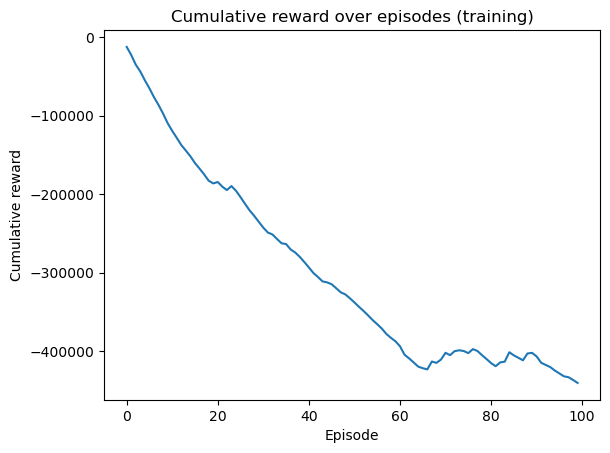

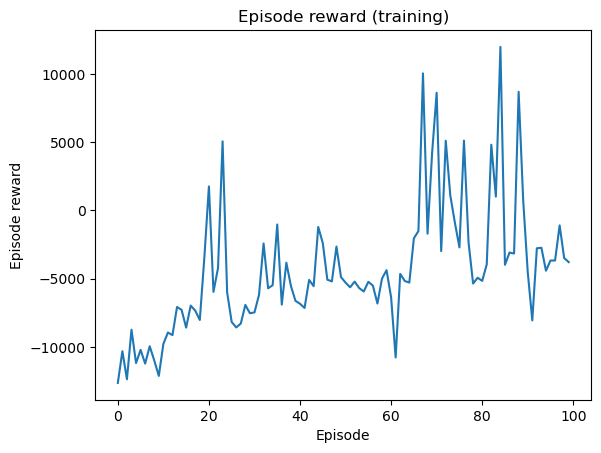

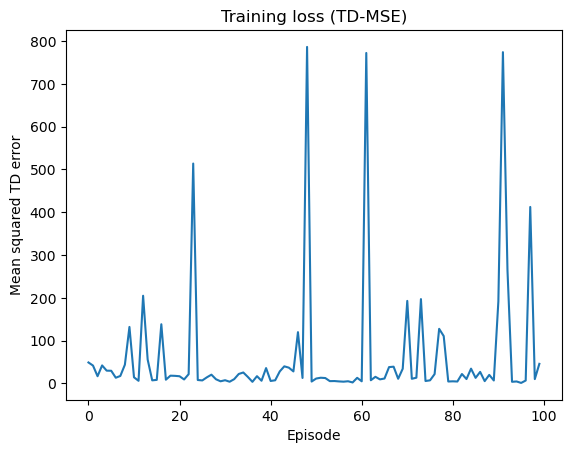

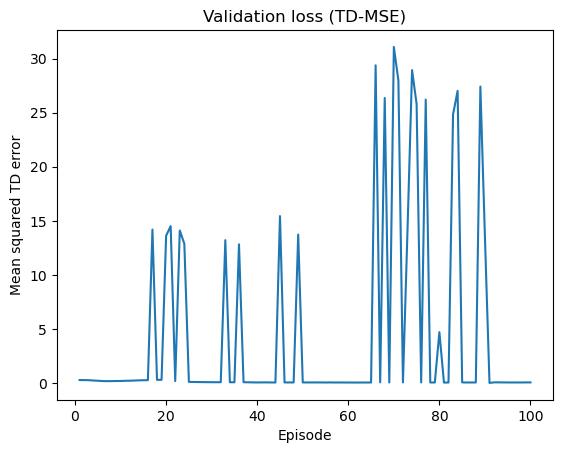

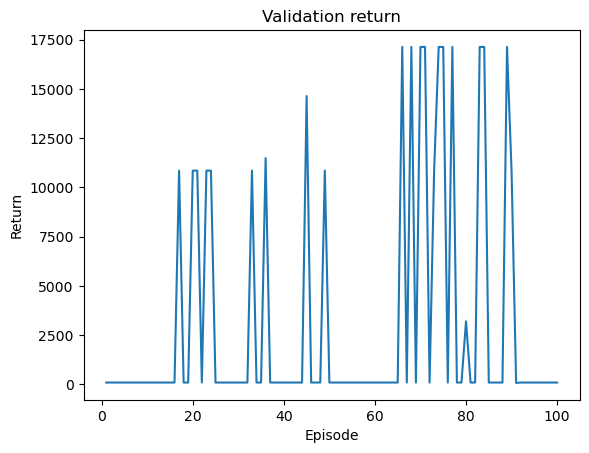

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Cumulative reward over episodes
plt.figure()
plt.plot(np.cumsum(episode_rewards))
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.title("Cumulative reward over episodes (training)")
plt.show()

# (Often also useful: per-episode reward)
plt.figure()
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Episode reward")
plt.title("Episode reward (training)")
plt.show()

# 2) Training loss
plt.figure()
plt.plot(episode_losses)
plt.xlabel("Episode")
plt.ylabel("Mean squared TD error")
plt.title("Training loss (TD-MSE)")
plt.show()

# 3) Validation loss (and optional validation return)
plt.figure()
plt.plot(val_episodes, val_losses)
plt.xlabel("Episode")
plt.ylabel("Mean squared TD error")
plt.title("Validation loss (TD-MSE)")
plt.show()

plt.figure()
plt.plot(val_episodes, val_returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Validation return")
plt.show()
